## Install Dependencies

In [1]:
!pip install ray[rllib]
!pip install tensorflow
!pip install gym
!pip install numpy

In [1]:
import gym
import random
import numpy as np

## Build the Gym Environment

In [2]:
class Car_v0(gym.Env):
    def __init__(self):
        # the action space ranges [0, 1, 2] where:
        #  `0` slow down
        #  `1` keep speed
        #  `2` speed up
        self.action_space = gym.spaces.Discrete(3)

        # speed array, must contain every possible state, in this case it is speed from 0 to 100
        self.observation_space = gym.spaces.Discrete(100+1)

        # generate initial values
        self.state = 57 + random.randint(-5, 5)  # simulation starts at a random speed from 52 to 62
        self.drive_length = 60  # total time of each episode (60 seconds)
        self.reward = 0  # blank variable to hold the reward of each move

    def reset(self):
        # resets state, time, and reward to initial values
        self.state = 57 + random.randint(-5, 5)
        self.drive_length = 60
        return self.state  # function must return the initial state

    def step(self, action):
        # executes each action and calculates reward
        done = False
        reward = 0
        # remove 1 second from time
        self.drive_length -= 1
        # apply the action (-1, 0, or 1 added to speed)
        self.state += action - 1

        # Calculate rewards; positive if between speed of 57 and 61, else negative
        if self.state >= 57 and self.state <= 61:
            reward = 1
        else:
            reward = -1

        # check if episode time is over
        if self.drive_length <= 0:
            done = True

        # add some random changes in speed for variability in episodes
        self.state += random.randint(-1, 1)
        
        self.reward = reward

        # return [state, reward, done, info]
        return self.state, reward, done, {}

    def render(self, mode="human"):
        # just prints out the current speed and reward given on each step (uncomment the 2 lines below)
        #s = "speed: {:2d}  reward: {:2d}"
        #print(s.format(self.state, self.reward))
        pass

## Test the Environment

In [3]:
# instantiate the environment
env = Car_v0()
sum_total = 0

# run through 10 episodes
episodes = 10
for x in range(0, episodes):
    state = env.reset()
    done = False
    reward = 0
    sum_reward = 0

    while not done:
        env.render()
        # will do a random action each time
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        sum_reward += reward
     
    # print the episode summary
    print('Episode:{} Score:{}'.format(x, sum_reward))

Episode:0 Score:-16
Episode:1 Score:14
Episode:2 Score:-20
Episode:3 Score:-52
Episode:4 Score:-20
Episode:5 Score:-46
Episode:6 Score:-14
Episode:7 Score:-20
Episode:8 Score:-20
Episode:9 Score:-50


## Initialize Ray

In [4]:
import ray
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

ray.init()

RayContext(dashboard_url='', python_version='3.8.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:64709', 'raylet_socket_name': 'tcp://127.0.0.1:62887', 'webui_url': '', 'session_dir': 'C:\\Users\\GGORCZ~1\\AppData\\Local\\Temp\\ray\\session_2022-08-29_08-48-23_139358_22332', 'metrics_export_port': 62339, 'gcs_address': '127.0.0.1:65015', 'address': '127.0.0.1:65015', 'node_id': 'eef308fdc11703f86049eb927c460008366273bc46300e90635b5bd7'})

## Train with RLlib

In [5]:
# first register environment to use with RLlib
register_env('car-v0', lambda config: Car_v0())

# instantiate the RL algorithm, chose PPO for simplicity
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"

# build a trainer object with the algorithm and enviroment
trainer = ppo.PPOTrainer(config, env='car-v0')

status = "{:2d} rewards: min {:6.2f} / mean {:6.2f} / max {:6.2f} saved {}"

for i in range(20):
   # Perform one iteration of training the policy with PPO
    result = trainer.train()
    checkpoint = trainer.save()
    # prints out the result of each training iteration
    print(status.format(
                i + 1,
                result["episode_reward_min"],
                result["episode_reward_mean"],
                result["episode_reward_max"],
                checkpoint
                ))

2022-08-29 08:48:29,927	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-08-29 08:48:29,930	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-08-29 08:48:29,930	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=9748) 2022-08-29 08:48:39,028	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=792) 202

 1 rewards: min -60.00 / mean -23.33 / max  40.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000001\checkpoint-1
 2 rewards: min -60.00 / mean -10.62 / max  54.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000002\checkpoint-2
 3 rewards: min -60.00 / mean  15.00 / max  60.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000003\checkpoint-3
 4 rewards: min -24.00 / mean  39.62 / max  60.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000004\checkpoint-4
 5 rewards: min -10.00 / mean  47.38 / max  60.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000005\checkpoint-5
 6 rewards: min -10.00 / mean  51.12 / max  60.00 saved C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-29_08-48-29kb34eq9n\checkpoint_000006\checkpoint-6
 7 rewards: min 

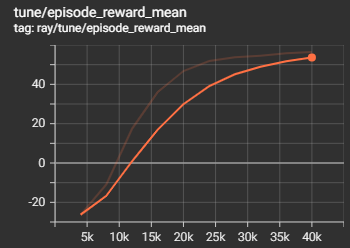

Chart shows the increase in average reward over many steps of training.

## Use the Trained Model

In [11]:
policy = trainer.get_policy()
model = policy.model
# prints a summary of the model
print(model.base_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 101)]        0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          26112       ['observations[0][0]']           
                                                                                                  
 fc_value_1 (Dense)             (None, 256)          26112       ['observations[0][0]']           
                                                                                                  
 fc_2 (Dense)                   (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                              

In [13]:
# get the trained model
trainer.restore(checkpoint)
env = Car_v0()

# run it through 10 episodes, the same way the environment was tested
episodes = 10
for x in range(1, episodes+1):
    state = env.reset()
    done = False
    reward = 0
    sum_reward = 0

    while not done:
        env.render()
        action = trainer.compute_action(state)
        state, reward, done, info = env.step(action)
        sum_reward += reward
     
    print('Episode:{} Score:{}'.format(x, sum_reward))

2022-08-16 12:43:15,402	INFO trainable.py:588 -- Restored on 127.0.0.1 from checkpoint: C:\Users\ggorczyca/ray_results\PPOTrainer_car-v0_2022-08-16_12-41-20tq3m0zpt\checkpoint_000020\checkpoint-20
2022-08-16 12:43:15,403	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 93.70845484733582, '_episodes_total': 1332}


Episode:1 Score:60
Episode:2 Score:60
Episode:3 Score:54
Episode:4 Score:56
Episode:5 Score:60
Episode:6 Score:60
Episode:7 Score:60
Episode:8 Score:54
Episode:9 Score:58
Episode:10 Score:54


You can see that the score is close to the max of 60 every time, which means that the trained model does well after just 20 episodes of training.